First, import needed modules

In [1]:
import numpy as np
import pandas as pd
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely.speedups
from shapely import wkt
from shapely.ops import unary_union

Initalize variables

In [2]:
shapely.speedups.enable()
path = os.getcwd()
print(path)

/Users/jan/Dropbox/UP_EPQM/2222/MA/powerlinemonsters


Load shapefile with municipality and state boundaries and plot it for inspection

<AxesSubplot:>

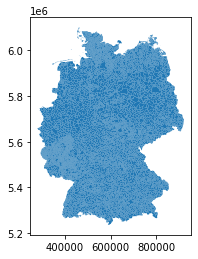

In [3]:
municipalities = gpd.read_file(f'{path}/data/geodata/VG250_GEM.shp')
mun = pd.DataFrame(municipalities).drop(columns='geometry')
states = gpd.read_file(f'{path}/data/geodata/VG250_LAN.shp')
municipalities.plot()

Inspect the dataframe: GEN has the municipalities' names, geometry are the polygons.


In [6]:
municipalities.head()
#mun_pd = pd.DataFrame(municipalities.drop(columns='geometry'))

Drop polygons which represent waterbodies and gemeindefreie Gebiete (mostly forests), here # of Inhabitats (EWZ) == 0

<AxesSubplot:>

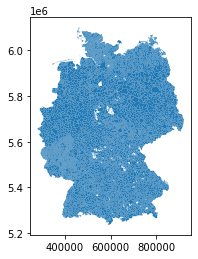

In [5]:
municipalities = municipalities[municipalities['GF'] == 4] 
municipalities = municipalities[municipalities["BEZ"] != 'Gemeindefreies Gebiet']
municipalities.plot()

The data use the European Terrestrial Reference System 1989 as coordinate reference system (CRS), units are metres

In [ ]:
municipalities.crs

Load shapefiles with power lines, start and endpoints

In [ ]:
powerlines = gpd.read_file(f'{path}/data/geodata/powerlines.shp')
startpoints = gpd.read_file(f'{path}/data/geodata/startpoints.shp')
endpoints = gpd.read_file(f'{path}/data/geodata/endpoints.shp')
powerlines.head()

Plot for inspection

In [ ]:
powerlines.plot()

Combine municipalities and powerlines in a plot

In [ ]:
powerlines.set_geometry('geometry')
fig, ax = plt.subplots(figsize=(10, 8), dpi=300)
ax.set_aspect('equal')
ax.set_axis_off()
municipalities.plot(ax=ax, color='lightblue', edgecolor='blue', lw=0.01, zorder=1)
states.boundary.plot(ax=ax, color='black', lw = 0.1, zorder=2)
powerlines.plot(ax=ax, color='red', lw=2, zorder=3)
plt.title('BBPlG 2013 projects \n All projects (new and retrofit)', fontsize=20)
plt.savefig(f'{path}/figures/BBPLG2013_all_projects.png')
plt.close()

Filter out Retrofitting projects

In [ ]:
powerlines = powerlines[powerlines['New'] == 1]
startpoints = startpoints[startpoints['New'] == 1]
endpoints = endpoints[endpoints['New'] == 1]
powerlines.head()

Filter out short lines and intermediate start- and endpoints

In [ ]:
powerlines = powerlines[powerlines['Short'].isna()]
startpoints = startpoints[startpoints['Int_start'].isna()]
endpoints = endpoints[endpoints['Int_end'].isna()]
powerlines.plot()

Combine municipalities and NEW powerlines in a plot

In [ ]:
powerlines.set_geometry('geometry')
fig, ax = plt.subplots(figsize=(10, 8), dpi=300)
ax.set_aspect('equal')
ax.set_axis_off()
municipalities.plot(ax=ax, color='lightblue', edgecolor='blue', lw=0.01, zorder=1)
states.boundary.plot(ax=ax, color='black', lw = 0.1, zorder=2)
powerlines.plot(ax=ax, color='red', lw=2, zorder=3)

startpoints.plot(ax=ax, color='red', lw=1, zorder=4)
endpoints.plot(ax=ax, color='red', lw=0.5, zorder=5)
'''
for x, y, label in zip(startpoints.geometry.x, startpoints.geometry.y, startpoints.Start):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", fontsize=5)
for x, y, label in zip(endpoints.geometry.x, endpoints.geometry.y, endpoints.End):
    ax.annotate(label, xy=(x, y), xytext=(-3, 3), textcoords="offset points", fontsize=5)
'''
plt.title('BBPlG 2013 projects \n New projects', fontsize=20)
plt.savefig(f'{path}/figures/BBPLG2013_new_projects.png')
plt.close()

Create buffers around the straight lines to create treatment indicator for different corridor widths

In [ ]:
for buffer in (5, 10, 15, 25, 50):
    try:
        powerlines.insert(loc=len(powerlines.columns), column=f'geometry_{buffer*2}', value=0) #buffer is added on both sides -> x2 to simplify
    except Exception:
        pass
    powerlines[f'geometry_{buffer*2}'] = powerlines['geometry'].buffer(buffer*1000)
powerlines.rename(columns = {'geometry':'geometry_0'}, inplace = True)
powerlines.head()

Now generate treatment indicators for all buffer sizes

In [ ]:
for buffer in (0, 5, 10, 15, 25, 50):
    try:
        municipalities.insert(loc=len(municipalities.columns), column=f'treated_{buffer*2}', value=0)
    except Exception:
        pass
    for i in range(len(municipalities)):
        # this sets treated_x = True, if powerline intersects a municipality
        municipalities.loc[municipalities.index[i], f'treated_{buffer*2}'] = any(powerlines[f'geometry_{buffer*2}'].intersects(municipalities['geometry'].values[i]))
municipalities.head()

In [ ]:
print(municipalities['treated_0'].describe())

Set treatment = False if municipality is a start- or endpoint

In [ ]:
for buffer in (0, 5, 10, 15, 25, 50):
    for i in range(len(municipalities)):
        # this sets treated_x = False if municipality contains a start- or endpoint
        if any(startpoints['geometry'].within(municipalities['geometry'].values[i])):
            municipalities.loc[municipalities.index[i], f'treated_{buffer*2}'] = False
        elif any(endpoints['geometry'].within(municipalities['geometry'].values[i])):
            municipalities.loc[municipalities.index[i], f'treated_{buffer*2}'] = False

In [ ]:
print(municipalities['treated_0'].describe())

Export treatment dataset from municipalities dataframe

In [ ]:
treatment = pd.DataFrame(municipalities)
treatment = treatment.reindex(columns=['AGS', 'GEN', 'treated_0', 'treated_10', 'treated_20', 'treated_30', 'treated_50', 'treated_100'])
treatment = treatment.set_index('AGS')
treatment = treatment.replace({True:1, False:0})
treatment.to_csv(f'{path}/data/treatment.csv', encoding = 'utf-8-sig')
treatment.head()

Plot the municipalities that directly intersect with a powerline

In [ ]:
powerlines = powerlines.set_geometry('geometry_0')
municipalities_intersected = municipalities[municipalities['treated_0'] == True] #drops all untreated munipalities
fig, ax = plt.subplots(figsize=(10, 8), dpi=300)
ax.set_aspect('equal')
ax.set_axis_off()
municipalities.plot(ax=ax, color='lightblue', edgecolor='blue', lw=0.01, zorder=1)
states.boundary.plot(ax=ax, color='darkblue', lw = 0.1, zorder=2)
municipalities_intersected.plot(ax=ax, color='orange', edgecolor='darkorange', lw=0.01, zorder=3)
powerlines.plot(ax=ax, color='red', lw=2, zorder=4)
plt.title('Municipalities affected by BBPlG 2013 projects \n direct line', fontsize=20)
plt.savefig(f'{path}/figures/BBPLG2013_treated_0.png')
plt.close()

Plot the municipalities that intersect with a powerline 50 km buffer

In [ ]:
powerlines.set_geometry('geometry_50')
municipalities_intersected50 = municipalities[municipalities['treated_50'] == True] #drops all untreated munipalities
fig, ax = plt.subplots(figsize=(10, 8), dpi=300)
ax.set_aspect('equal')
ax.set_axis_off()
municipalities.plot(ax=ax, color='lightblue', zorder=1)
states.boundary.plot(ax=ax, color='darkblue', lw = 0.1, zorder=2)
municipalities_intersected50.plot(ax=ax, color='orange', edgecolor='darkorange', lw=0.01, zorder=3)
powerlines.plot(ax=ax, color='red', lw=2, zorder=4)
plt.title('Municipalities affected by BBPlG 2013 projects \n with a 50km buffer', fontsize=20)
plt.savefig(f'{path}/figures/BBPLG2013_treated_50.png')
plt.close()